In [1]:
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt

import qiskit
from qiskit import *
from qiskit.opflow import X,Z,I
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA
from qiskit.opflow import CircuitSampler

from qiskit.ignis.mitigation.measurement import CompleteMeasFitter # you will need to pip install qiskit-ignis

from scipy import sparse
import scipy.sparse.linalg.eigen.arpack as arp
from modules.utils import *

In [7]:
IBMQ.load_account() # this then automatically loads your saved account
provider = IBMQ.get_provider(hub='ibm-q-research')

In [8]:
device = provider.backend.ibmq_rome
print(device)

ibmq_rome


In [9]:
#backend = device
backend = qiskit.providers.aer.AerSimulator.from_backend(device)

In [10]:
coupling_map = device.configuration().coupling_map
noise_model = qiskit.providers.aer.noise.NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

In [11]:
#aqua_globals.random_seed = seed
qi = qiskit.utils.QuantumInstance(backend=backend, # , seed_simulator=seed, seed_transpiler=seed
                         coupling_map=coupling_map, noise_model=noise_model,
                         measurement_error_mitigation_cls= CompleteMeasFitter, 
                         cals_matrix_refresh_period=30  #How often to refresh the calibration matrix in measurement mitigation. in minutes
                                 )

In [12]:
# linear entangler (as in scales linearly with trash qubits)
def get_entangler_map(L, num_trash, i_permut=1):
    result = []
    nums = list(range(L)) # here was the problem, it doesnt like when list elements are taken from numpy
    nums_compressed = nums.copy()[:L-num_trash]
    nums_trash = nums.copy()[-num_trash:]
    #print(nums, nums_compressed, nums_trash)
    # combine all trash qubits with themselves
    for trash_q in nums_trash[:-1]:
        result.append((trash_q+1,trash_q))
    # combine each of the trash qubits with every n-th
    repeated = list(nums_trash) * (L-num_trash) # repeat the list of trash indices cyclicly
    for i in range(L-num_trash):
        result.append((repeated[i_permut + i], nums_compressed[i]))
    return result

def QAE_Ansatz(thetas, L, num_trash, insert_barriers=False, parametrized_gate = "ry", entangling_gate = "cz"):
    entanglement = [get_entangler_map(L,num_trash,i_permut) for i_permut in range(num_trash)]
    circ = qiskit.circuit.library.TwoLocal(L, 
                                           parametrized_gate,
                                           entangling_gate,
                                           entanglement,
                                           reps=num_trash,
                                           insert_barriers=insert_barriers,
                                           skip_final_rotation_layer=True
                                          ).assign_parameters(thetas[:-num_trash])
    if insert_barriers: circ.barrier()
    for i in range(num_trash):
        circ.ry(thetas[L-i-1], L-i-1)
        #circ.ry(circuit.Parameter(f'θ{i}'), L-i-1)
    return circ

def prepare_circuit(thetas, L=6, num_trash=2, init_state=None, measurement=True, vqe=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(num_trash, 'c')
    circ = QuantumCircuit(qreg, creg)
    circ += QAE_Ansatz(thetas, L, num_trash, insert_barriers=True)#.assign_parameters(thetas) # difference to bind?
    if measurement:
        for i in range(num_trash):
            circ.measure(qreg[L-i-1], creg[i])
    if init_state is not None:
        if vqe:
            circ = init_vqe(init_state,L=L) + circ
        else:
            circ.initialize(init_state, qreg)
    return circ, qreg

In [13]:
def feature_encoding(thetas, x):
    """ thetas: parameters to be optimized, x: Ising model parameter (eg. field) """
    new_thetas = []
    thetas = thetas.reshape((-1,2))
    for theta in thetas:
        new_thetas.append(theta[0] * x + theta[1])
    return new_thetas

# Measurement Error mitigation
I have low hopes this will actually do something

In [15]:
backend_sim = backend

In [16]:
def run_circuit(thetas, L, num_trash, init_state, vqe=True, shots=100):
    circ, qreg = prepare_circuit(thetas, L, num_trash, init_state, vqe=vqe)

    # Execute the circuit on the qasm simulator.
    job_sim = execute(circ, backend_sim, shots=shots, seed_simulator=123, seed_transpiler=234) # fix seed to make it reproducible

    # Grab the results from the job.
    result_sim = job_sim.result()

    counts = result_sim.get_counts(circ)
#     print(counts)
    
#     mems = result_sim.get_memory(circ)
#     print(mems)
    return counts
L = 5
num_trash = 2
phi = np.random.rand(40)
thetas = np.random.uniform(0, 2*np.pi, 2*L+2)
run_circuit(thetas, L, num_trash, phi)['11']

18

In [17]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal

In [18]:
circ, qreg = prepare_circuit(thetas, L, num_trash, phi)

In [19]:
qubit_list = [L-i-1 for i in range(num_trash)] # only need to calibrate the trash qubits

In [20]:
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qreg, circlabel='mcal')

In [21]:
job = qiskit.execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

In [22]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

In [23]:
print(meas_fitter.cal_matrix)

[[0.982 0.033 0.039 0.002]
 [0.01  0.955 0.    0.032]
 [0.008 0.001 0.955 0.036]
 [0.    0.011 0.006 0.93 ]]


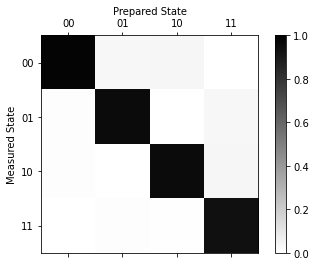

In [24]:
meas_fitter.plot_calibration()

In [25]:
job_sim = execute(circ, backend, shots=1000) # fix seed to make it reproducible

In [26]:
result = job_sim.result()

In [27]:
# Results without mitigation
raw_counts = result.get_counts()

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(result)
mitigated_counts = mitigated_results.get_counts(0)

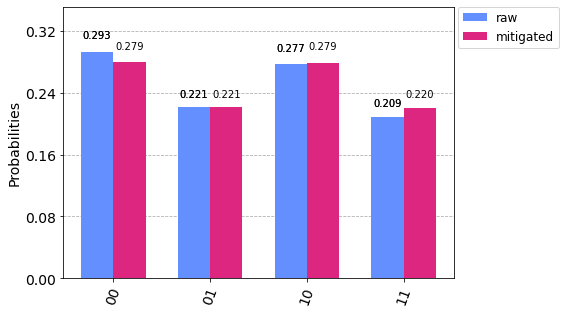

In [28]:
from qiskit.tools.visualization import *
plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'])